# 实操：基于 DeltaFQ 实现量化策略模板（v0.5.0）

本教程将演示如何使用 DeltaFQ 实现一个完整的量化策略回测流程，使用布林带（BOLL）指标作为示例。

## 策略参数设置

- **标的**: 518880.SS（黄金ETF）
- **基准**: 000300.SS（沪深300）
- **回测周期**: 2023-01-01 至 2025-10-30
- **布林带参数**: 周期=5，标准差倍数=1.5
- **交易参数**: 初始资金=1,000,000，手续费=0.1%，滑点=0.05%

## 策略逻辑

- **买入信号**: 价格上穿布林带下轨
- **卖出信号**: 价格下穿布林带上轨

## 实现方式

本教程提供两种实现方式：
1. **方法一**: 分别调用不同的类，一步步实现（适合理解底层流程）
2. **方法二**: 使用 BaseStrategy + BacktestEngine 极简实现（适合快速开发）


In [1]:
# 导入必要的库
import deltafq as dfq
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 全局参数设置
ticker = "518880.SS"  # 黄金ETF
benchmark_ticker = "000300.SS"  # 沪深300
start_date = "2023-01-01"
end_date = "2025-10-30"

# 策略参数
boll_period = 5
boll_k = 1.5  # 标准差倍数

# 交易参数
initial_capital = 1_000_000
commission = 0.001  # 0.1%
slippage = 0.0005  # 0.05%

print("✅ 参数设置完成")
print(f"标的: {ticker}")
print(f"基准: {benchmark_ticker}")
print(f"回测周期: {start_date} 至 {end_date}")
print(f"布林带参数: 周期={boll_period}, 标准差倍数={boll_k}")
print(f"初始资金: {initial_capital:,.0f}, 手续费: {commission*100}%, 滑点: {slippage*100}%")


✅ 参数设置完成
标的: 518880.SS
基准: 000300.SS
回测周期: 2023-01-01 至 2025-10-30
布林带参数: 周期=5, 标准差倍数=1.5
初始资金: 1,000,000, 手续费: 0.1%, 滑点: 0.05%


## 方法一：分别调用不同的类，一步步实现

这种方式适合理解底层流程，每一步都清晰可见。


方法一：分步实现

【步骤1】数据获取
[13:40:01] DataFetcher          >>> INFO     >>> Initializing data fetcher with source: yahoo
[13:40:01] DataFetcher          >>> INFO     >>> Fetching data for 518880.SS from 2023-01-01 to 2025-10-30
[13:40:11] DataCleaner          >>> INFO     >>> Initializing data cleaner
[13:40:11] DataCleaner          >>> INFO     >>> Dropped NaN rows: 681 -> 681 rows
[13:40:11] DataFetcher          >>> INFO     >>> Fetching data for 000300.SS from 2023-01-01 to 2025-10-30
[13:40:12] DataCleaner          >>> INFO     >>> Dropped NaN rows: 682 -> 682 rows
✅ 获取数据完成: 518880.SS (681条), 000300.SS (682条)

【步骤2】计算技术指标
[13:40:12] TechnicalIndicators  >>> INFO     >>> Initializing technical indicators
[13:40:12] TechnicalIndicators  >>> INFO     >>> Calculating BOLL(period=5, std_dev=1.5, method=sample)
[13:40:12] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=5)
✅ 布林带计算完成: 周期=5, 标准差倍数=1.5

【步骤3】生成交易信号
[13:40:12] SignalGenerator      >>> INFO     >>> Initializing signal ge

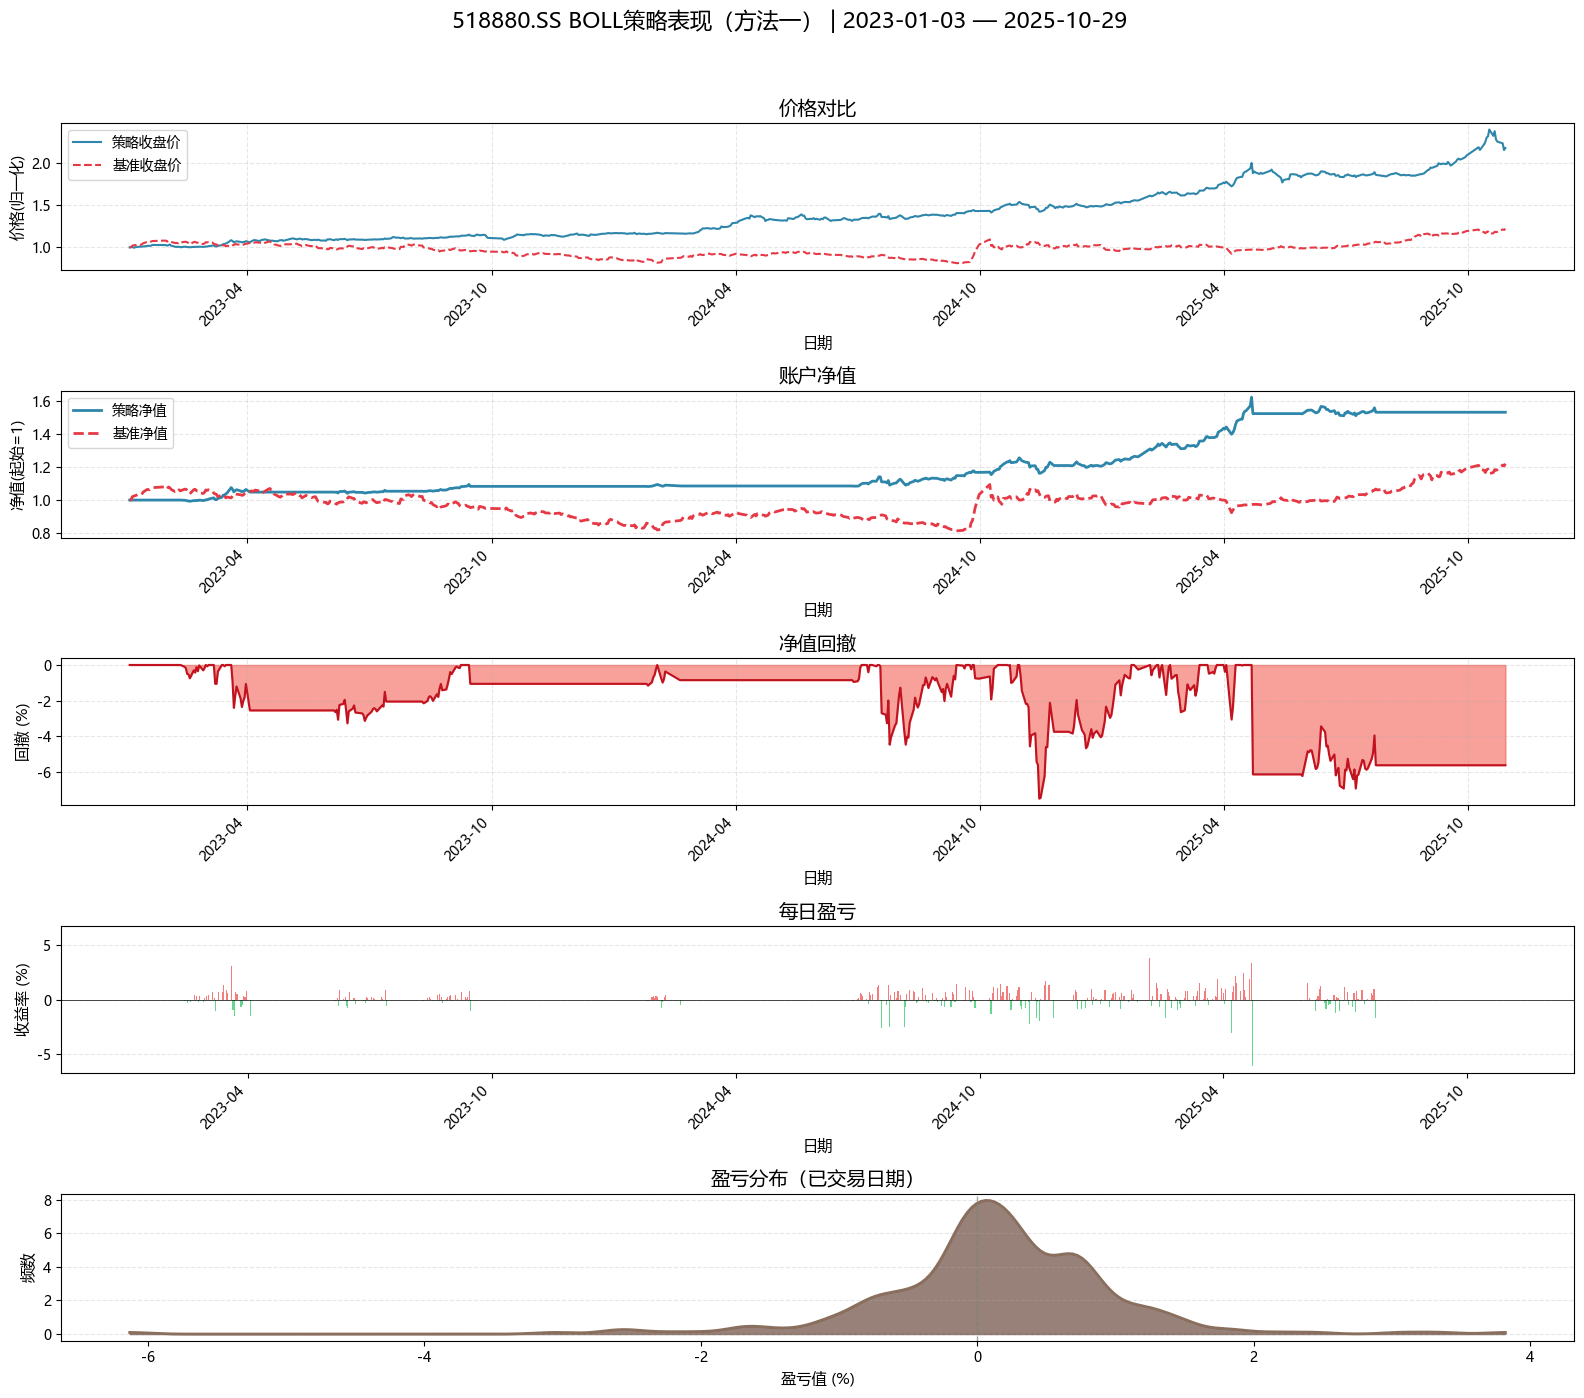


方法一完成！


In [2]:
# ========== 方法一：分步实现 ==========

print("=" * 80)
print("方法一：分步实现")
print("=" * 80)

# 1. 数据获取
print("\n【步骤1】数据获取")
fetcher = dfq.data.DataFetcher()
data = fetcher.fetch_data(ticker, start_date, end_date, clean=True)
benchmark_data = fetcher.fetch_data(benchmark_ticker, start_date, end_date, clean=True)
print(f"✅ 获取数据完成: {ticker} ({len(data)}条), {benchmark_ticker} ({len(benchmark_data)}条)")

# 2. 计算技术指标
print("\n【步骤2】计算技术指标")
indicators = dfq.indicators.TechnicalIndicators()
boll_bands = indicators.boll(data["Close"], period=boll_period, std_dev=boll_k, method="sample")
print(f"✅ 布林带计算完成: 周期={boll_period}, 标准差倍数={boll_k}")

# 3. 生成交易信号
print("\n【步骤3】生成交易信号")
signals = dfq.strategy.SignalGenerator()
signal_series = signals.boll_signals(
    price=data["Close"], 
    bands=boll_bands, 
    method="cross_current"  # 对应参考文件中的上穿/下穿逻辑
)
buy_count = (signal_series == 1).sum()
sell_count = (signal_series == -1).sum()
print(f"✅ 信号生成完成: 买入信号={buy_count}次, 卖出信号={sell_count}次")

# 4. 运行回测
print("\n【步骤4】运行回测")
engine = dfq.backtest.BacktestEngine(
    initial_capital=initial_capital,
    commission=commission,
    slippage=slippage
)
trades_df, values_df = engine.run_backtest(
    symbol=ticker,
    signals=signal_series,
    price_series=data["Close"],
    strategy_name="BOLL_分步实现"
)
print(f"✅ 回测完成: 交易次数={len(trades_df)}, 记录天数={len(values_df)}")

# 5. 生成绩效报告
print("\n【步骤5】生成绩效报告")
reporter = dfq.backtest.PerformanceReporter()
reporter.print_summary(
    symbol=ticker,
    trades_df=trades_df,
    values_df=values_df,
    title=f"{ticker} BOLL策略回测报告（方法一）",
    language="zh"
)

# 6. 可视化结果
print("\n【步骤6】可视化结果")
chart = dfq.charts.PerformanceChart()
chart.plot_backtest_charts(
    values_df=values_df,
    benchmark_close=benchmark_data["Close"],
    title=f"{ticker} BOLL策略表现（方法一）",
    use_plotly=False
)

print("\n" + "=" * 80)
print("方法一完成！")
print("=" * 80)


## 方法二：使用 BaseStrategy + BacktestEngine 极简实现

这种方式代码更简洁，适合快速开发和策略迭代。


方法二：BaseStrategy + BacktestEngine 极简实现
[13:40:15] BOLLStrategy         >>> INFO     >>> Initializing strategy: BOLLStrategy

✅ 策略创建完成: BOLLStrategy
[13:40:15] BacktestEngine       >>> INFO     >>> Initializing backtest engine
[13:40:15] DataFetcher          >>> INFO     >>> Initializing data fetcher with source: yahoo
[13:40:15] DataStorage          >>> INFO     >>> Initializing data storage at: C:\Users\leek_\Desktop\Delta\imooc\deltafq\examples\data_cache
[13:40:15] PerformanceReporter  >>> INFO     >>> Initializing performance reporter
[13:40:15] PerformanceChart     >>> INFO     >>> Initializing performance chart
[13:40:15] OrderManager         >>> INFO     >>> Initializing order manager
[13:40:15] PositionManager      >>> INFO     >>> Initializing position manager
[13:40:15] OrderManager         >>> INFO     >>> Initializing order manager
[13:40:15] PositionManager      >>> INFO     >>> Initializing position manager
[13:40:15] DataFetcher          >>> INFO     >>> Initializing dat

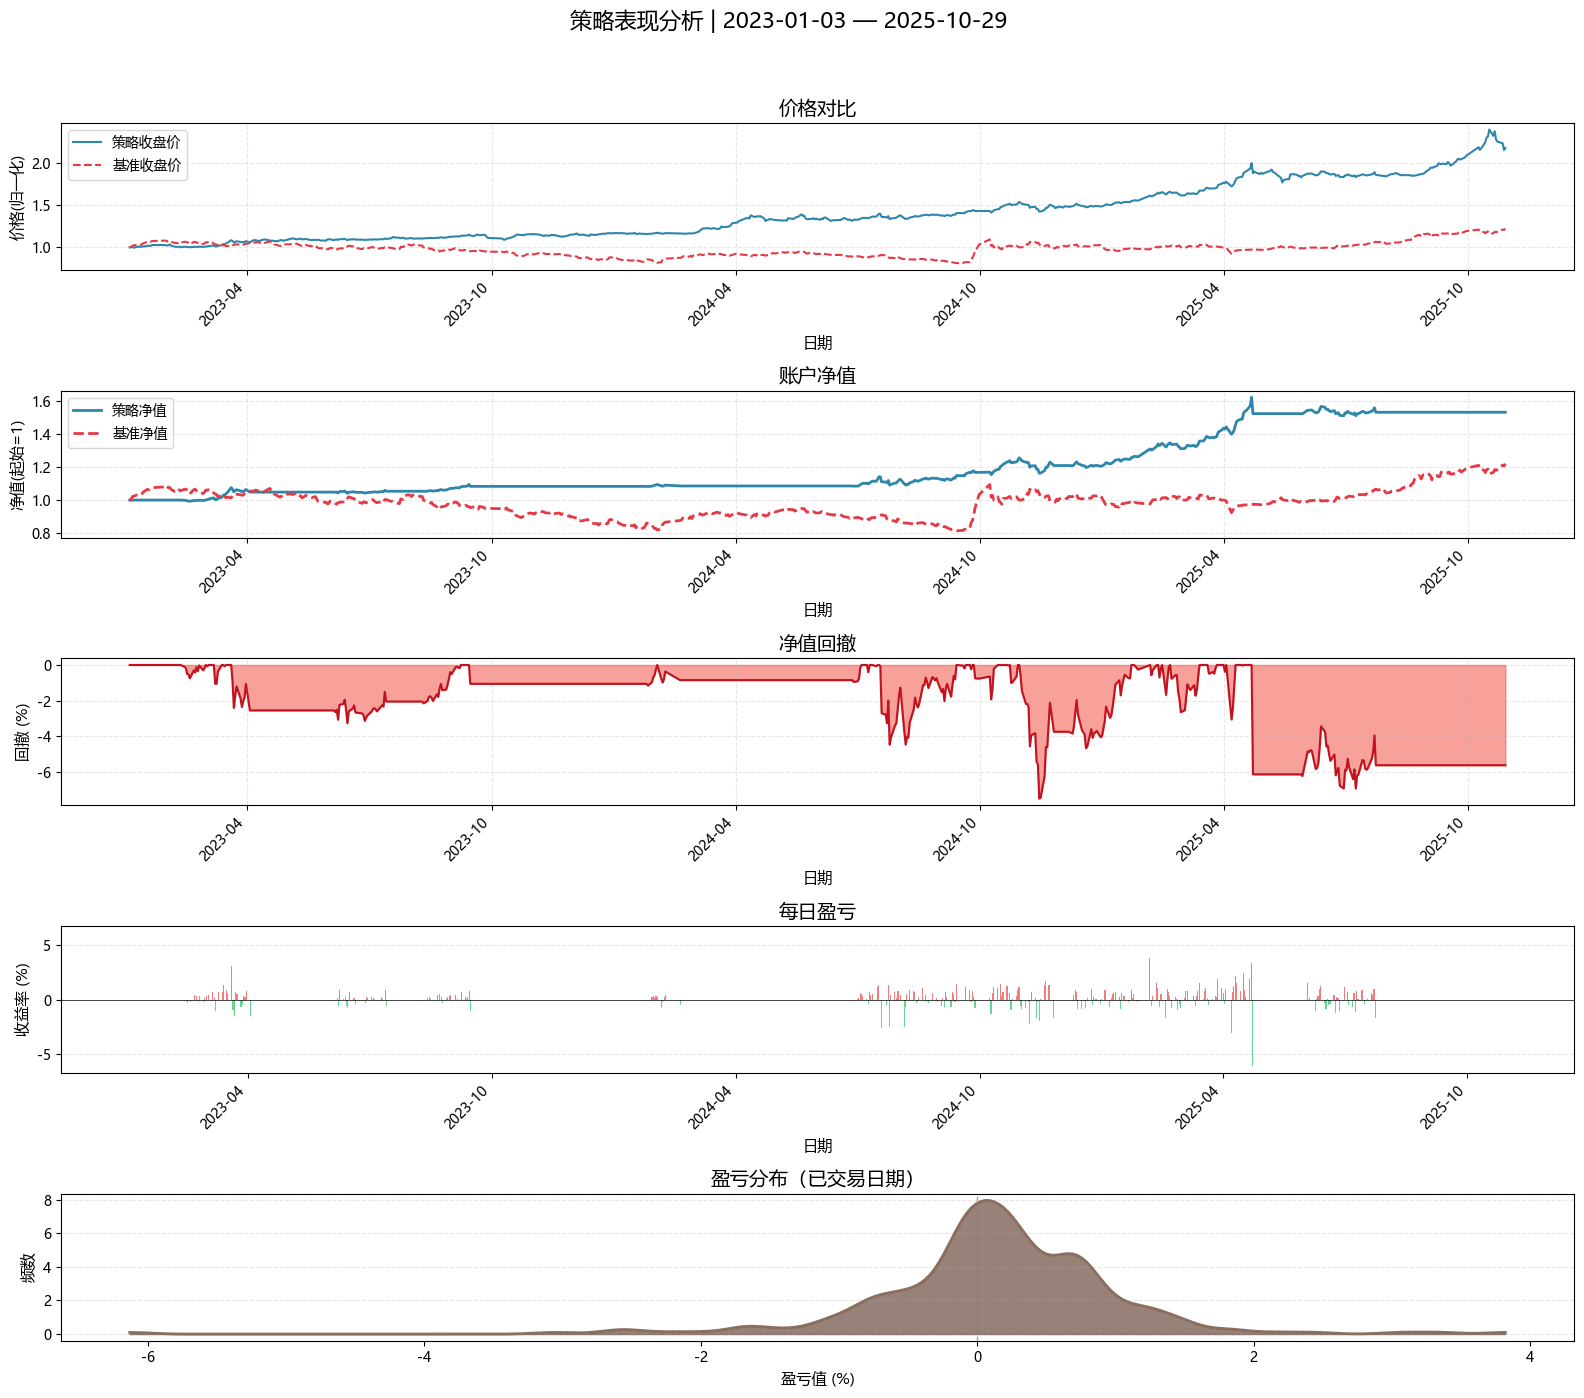


方法二完成！


In [3]:
# ========== 方法二：BaseStrategy + BacktestEngine 极简实现 ==========

print("=" * 80)
print("方法二：BaseStrategy + BacktestEngine 极简实现")
print("=" * 80)

# 1. 定义策略类（继承 BaseStrategy）
class BOLLStrategy(dfq.strategy.BaseStrategy):
    """基于布林带的交易策略"""
    
    def __init__(self, period=5, std_dev=1.5, **kwargs):
        super().__init__(name="BOLLStrategy", **kwargs)
        self.period = period
        self.std_dev = std_dev
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """生成交易信号"""
        # 计算布林带
        indicators = dfq.indicators.TechnicalIndicators()
        boll_bands = indicators.boll(
            data["Close"], 
            period=self.period, 
            std_dev=self.std_dev, 
            method="sample"
        )
        
        # 生成信号
        signals = dfq.strategy.SignalGenerator()
        signal_series = signals.boll_signals(
            price=data["Close"],
            bands=boll_bands,
            method="cross_current"
        )
        
        return signal_series

# 2. 创建策略实例
strategy = BOLLStrategy(period=boll_period, std_dev=boll_k)
print(f"\n✅ 策略创建完成: {strategy.name}")

# 3. 初始化回测引擎并设置参数
engine2 = dfq.backtest.BacktestEngine(
    initial_capital=initial_capital,
    commission=commission,
    slippage=slippage
)
engine2.set_parameters(
    symbol=ticker,
    start_date=start_date,
    end_date=end_date,
    benchmark=benchmark_ticker
)
print("✅ 回测引擎参数设置完成")

# 4. 加载数据
data2 = engine2.load_data()
print(f"✅ 数据加载完成: {len(data2)}条")

# 5. 添加策略并运行回测
engine2.add_strategy(strategy)
trades_df2, values_df2 = engine2.run_backtest(strategy_name="BOLL_极简实现")
print(f"✅ 回测完成: 交易次数={len(trades_df2)}, 记录天数={len(values_df2)}")

# 6. 生成绩效报告（使用引擎内置方法）
print("\n【步骤6】生成绩效报告")
engine2.show_report()

# 7. 可视化结果（使用引擎内置方法）
print("\n【步骤7】可视化结果")
engine2.show_chart(use_plotly=False)

print("\n" + "=" * 80)
print("方法二完成！")
print("=" * 80)


## 两种方法对比

### 方法一：分步实现
- ✅ **优点**: 流程清晰，每一步都可控，适合学习和调试
- ⚠️ **缺点**: 代码较多，需要手动管理各个组件

### 方法二：BaseStrategy + BacktestEngine
- ✅ **优点**: 代码简洁，封装良好，适合快速开发和策略迭代
- ⚠️ **缺点**: 需要理解 BaseStrategy 的继承机制

### 使用建议
- **学习阶段**: 使用方法一，理解每个步骤
- **生产环境**: 使用方法二，提高开发效率


In [4]:
# 对比两种方法的结果（可选）
print("\n" + "=" * 80)
print("两种方法结果对比")
print("=" * 80)

if len(values_df) > 0 and len(values_df2) > 0:
    final_value_1 = values_df['total_value'].iloc[-1]
    final_value_2 = values_df2['total_value'].iloc[-1]
    total_return_1 = (final_value_1 - initial_capital) / initial_capital
    total_return_2 = (final_value_2 - initial_capital) / initial_capital
    
    print(f"\n方法一最终资金: {final_value_1:,.2f} (收益率: {total_return_1:.2%})")
    print(f"方法二最终资金: {final_value_2:,.2f} (收益率: {total_return_2:.2%})")
    print(f"\n交易次数对比:")
    print(f"  方法一: {len(trades_df)} 笔")
    print(f"  方法二: {len(trades_df2)} 笔")
    
    # 验证两种方法结果是否一致（应该完全一致）
    if abs(final_value_1 - final_value_2) < 0.01:
        print("\n✅ 两种方法结果一致！")
    else:
        print(f"\n⚠️ 两种方法结果存在差异: {abs(final_value_1 - final_value_2):.2f}")
else:
    print("⚠️ 无法对比：缺少回测结果数据")



两种方法结果对比

方法一最终资金: 1,534,154.28 (收益率: 53.42%)
方法二最终资金: 1,534,154.28 (收益率: 53.42%)

交易次数对比:
  方法一: 14 笔
  方法二: 14 笔

✅ 两种方法结果一致！
